# Keyword Spotting: a neural attention model for speech command recognition
This notebook implements an attention model for speech command recognotion. It is obtained as a modification of a [Demo notebook](https://github.com/douglas125/SpeechCmdRecognition/blob/master/Speech_Recog_Demo.ipynb) prepared by the authors of the paper [A neural attention model for speech command recognition](https://arxiv.org/abs/1808.08929).

For more information, refer to the official GitHub repository: [douglas125/SpeechCmdRecognition](https://github.com/douglas125/SpeechCmdRecognition).

## Get scripts from GitHub and install wget
Only required when running on Colab. 

In [2]:
! pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=a0e44a28505adbce61eab09dec50bed7d5ac918dc768c816a54c8807543398b1
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [3]:
useColab=True
if useColab:
    %tensorflow_version 2.x
    ! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/models_utils.py
    ! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/plot_utils.py
    ! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/preprocessing_utils.py
    ! wget -nc https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    # ! wget -nc https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    # ! pip install -r requirements.txt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
--2023-01-26 10:16:04--  https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/models_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10904 (11K) [text/plain]
Saving to: ‘models_utils.py’

models_utils.py     100%[===================>]  10.65K  --.-KB/s    in 0s      

2023-01-26 10:16:04 (121 MB/s) - ‘models_utils.py’ saved [10904/10904]

--2023-01-26 10:16:04--  https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/plot_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443...

## Import

In [4]:
import os
import pathlib
import requests
import wget
import inspect

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from IPython.display import display, Audio, Image

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, log_loss, cohen_kappa_score

from scipy.io import wavfile

from models_utils import available_models, select_model
import plot_utils 

plt.rcParams['font.size'] = '12'
# %matplotlib inline

In [5]:
print("GPU Available:", tf.test.is_gpu_available())
print("Version:", tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True
Version: 2.9.2


To extract MFCC features from audio signals we use the Python library [python_speech_features](https://github.com/jameslyons/python_speech_features).

In [6]:
# uncomment to install python_speech_features
! pip install python_speech_features
! pip install visualkeras

from python_speech_features import logfbank, mfcc, delta
import visualkeras

import preprocessing_utils
from preprocessing_utils import create_dataset, remove_file_starting_with

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=31c28478505f232430e0f6f2faeb01e63c9403051ad1a104c6df5e004253b7ef
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 53.4 MB/s eta 0:00:00


To perform Discrete Wavelet Transform on audio signals we use the Python library [PyWavelets](https://github.com/PyWavelets/pywt).

In [7]:
# uncomment to install PyWavelets
! pip install PyWavelets

from pywt import dwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1 - Data loading 
In this project we use the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands), which contains short (one-second long) audio clips of English commands, stored as audio files in the WAV format. More in detail, the version 0.02 of the dataset contains 105.829 utterances of 35 short words, by thousands of different people. It was released on April 11th 2018 under [Creative Commons BY 4.0 license](https://creativecommons.org/licenses/by/4.0/) and collected using crowdsourcing, through [AIY](https://aiyprojects.withgoogle.com/) by Google. Some of these words are "yes", "no", "up", "down", "left", "right", "on", "off", "stop" and "go".

### 1.1 - Download data and create data folder
We import both a smaller version of the Speech Commands dataset and the full version. The mini dataset can be used for testing and demo reasons, however the entire work will be focused only on the complete dataset (or a subset of it). 

In [8]:
choose_dataset = 2 # 1 for mini, 2 for full
download_also_mini = False

DATASET_PATH_mini = 'data/mini_speech_commands'
DATASET_PATH_full = 'data/full_speech_commands'

data_dir_mini = pathlib.Path(DATASET_PATH_mini)
if not data_dir_mini.exists() and download_also_mini:
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
  print('\n')
  
data_dir_full = pathlib.Path(DATASET_PATH_full)
if not data_dir_full.exists():
  tf.keras.utils.get_file(
      'full_speech_commands.zip',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data/full_speech_commands')
  print('\n')
  
if choose_dataset==1:
  data_dir = data_dir_mini
  data_path = DATASET_PATH_mini
  print('Working with the mini dataset!')
elif choose_dataset==2:
  data_dir = data_dir_full
  data_path = DATASET_PATH_full
  print('Working with the full dataset!')
else:
  print("Error, 'choose_dataset' must be 1 or 2")

2428923189/2428923189 [==============================] - 9s 0us/step


Working with the full dataset!


### 1.1 - Dataset organization
The audio files are organized into folders based on the word they contain. For more details see \[[Warden18](https://arxiv.org/abs/1804.03209)\].

**Mini dataset** <br>
The dataset's audio clips are stored in 8 folders corresponding to each speech command: `down`, `go`, `left`, `no`, `right`, `stop`, `up`, `yes`, and `stop`. 

**Full dataset** <br>
The dataset's audio clips are stored in 35 folders corresponding to each speech command: <br>
`backward`, `bed`, `bird`, `cat`, `dog`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `happy`, `house`, `learn`, `left`, `marvin`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `sheila`, `six`, `stop`, `three`, `tree`, `two`, `up`, `visual`, `wow`, `yes`, `zero`




In [9]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

if choose_dataset==1:
  mask = commands != 'README.md'

elif choose_dataset==2:
  mask = (
      np.array(commands != 'README.md')                 &
      np.array(commands != 'LICENSE')                   &
      np.array(commands != '.DS_Store')                 &
      np.array(commands != 'training_list.txt')         &  
      np.array(commands != 'validation_list.txt')       &  
      np.array(commands != 'testing_list.txt')          &  
      np.array(commands != 'full_speech_commands.zip')  &
      np.array(commands != '_background_noise_')        
  )
  
commands = sorted(commands[mask])
print('Commands:', commands)

print('\nNumber of commands: %i' %len(commands))

Commands: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

Number of commands: 35


### 1.2 - Processing of the original audio files 
The original audio files were captured in a variety of formats and then converted to .WAV file at a 16000 sample rate. The audio was then trimmed to a one second length to align most utterances, using the [extract_loudest_section](https://github.com/petewarden/extract_loudest_section) tool. The audio files were then screened for silence or incorrect words, and arranged into folders by label.

### 1.3 - Training, testing and validation sets
The text files `validation_list.txt` and `testing_list.txt` available in the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) contain the paths to all the files in each set, with each path on a new line. Any files that aren't in either of these lists can be considered to be part of the training set. The validation and test set sizes thus obtained are approximatly 10% of the size of the complete set. For more information on how the partition is made, see the README.md file of the dataset. 

The following code performs these operations:
- Load the reference validation and testing files as separated Pandas dataframe objects. 
- Store the path of all audio files in a dictionary. 
- Create the reference file for training data, by storing in a Pandas dataframe object the paths of all files that aren't in the validation or testing list. If it has been already created, we simply import it as we did for the reference validation and testing files. 

To each file we associate the corresponding label (i.e. the name of the folder it is in), so that we get a proper labeling for each file to be used with our loss function. Of course, we still need to load the actual data.

In [10]:
training_list_path = data_path + "/training_list.txt"

reference_df_val = pd.read_csv(data_path+"/validation_list.txt", sep="/", header=None, names=['label', 'file'])
reference_df_test = pd.read_csv(data_path+"/testing_list.txt", sep="/", header=None, names=['label', 'file'])

# all audio files
all_files = {}
for command in commands:
    all_files[command] = os.listdir(data_path+'/'+command)
    
num_files = 0
for x_ in all_files.values():
    num_files += len(x_)
        
print('There are %i audio files in the dataset' %num_files)

# reference file for training set
# if already exists import it
if pathlib.Path(training_list_path).exists(): 
    reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])
    
# else search if it can be dowloaded
else: 
  training_list_url = 'https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/training_list.txt'
  response = requests.get(training_list_url)

  if response.status_code == 200:
      wget.download(training_list_url, out=str(data_path))
      print('File downloaded from GitHub')

      reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])

  else: # create it and store the dataframe as a .txt file; creating the pd object can take some time
      print('File not found, error '+str(response.status_code))

      reference_df_train = pd.DataFrame(columns=['label', 'file'])
      for i, command in enumerate(commands):
          print("Processing command '%s', %i commands missing..." %(command, len(commands)-i-1))
          for file in all_files[command]:
              if file in reference_df_val['file'].values:
                  continue
              if file in reference_df_test['file'].values:
                  continue

              reference_df_train.loc[len(reference_df_train)] = [command, file]

      print('Done!')
      print('\n')

      # store reference_df_train in .txt file
      reference_df_train.to_csv(data_path+'/training_list.txt', header=None, index=None, sep='/', mode='a')

# print the result
# print('----------------------------')
# print('TRAINING FILES:')
# print(reference_df_train)
# print('----------------------------')
# print('VALIDATION FILES:')
# print(reference_df_val)
# print('----------------------------')
# print('TESTING FILES:')
# print(reference_df_test)

There are 105829 audio files in the dataset
File downloaded from GitHub


Encode target labels with value between 0 and n_commands-1.

In [11]:
label_to_class = {commands[i]:i for i in range(len(commands))}
# label_to_class

In [12]:
class_to_label = {i:commands[i] for i in range(len(commands))}
# class_to_label

In [13]:
reference_df_train['class'] = reference_df_train['label'].map(label_to_class)
reference_df_val['class']   = reference_df_val['label'].map(label_to_class)
reference_df_test['class']  = reference_df_test['label'].map(label_to_class)

# print the result
print('TRAINING FILES:')
print(reference_df_train)
print('----------------------------')
print('VALIDATION FILES:')
print(reference_df_val)
print('----------------------------')
print('TESTING FILES:')
print(reference_df_test)

TRAINING FILES:
          label                   file  class
0      backward  0165e0e8_nohash_0.wav      0
1      backward  017c4098_nohash_0.wav      0
2      backward  017c4098_nohash_1.wav      0
3      backward  017c4098_nohash_2.wav      0
4      backward  017c4098_nohash_3.wav      0
...         ...                    ...    ...
84838      zero  ffd2ba2f_nohash_1.wav     34
84839      zero  ffd2ba2f_nohash_2.wav     34
84840      zero  ffd2ba2f_nohash_3.wav     34
84841      zero  ffd2ba2f_nohash_4.wav     34
84842      zero  fffcabd1_nohash_0.wav     34

[84843 rows x 3 columns]
----------------------------
VALIDATION FILES:
      label                   file  class
0     right  a69b9b3e_nohash_0.wav     22
1     right  439c84f4_nohash_1.wav     22
2     right  409c962a_nohash_1.wav     22
3     right  dbaf8fc6_nohash_2.wav     22
4     right  a6d586b7_nohash_1.wav     22
...     ...                    ...    ...
9976   four  d107dc42_nohash_0.wav     10
9977   four  ad63d93c_n

### 1.4 Noise loading 
We load here the available noisy audio signals and we defined the object `noise_dict`, which is required by the function `load_and_preprocessing_data` (see next section).

In [14]:
noise_path = '_background_noise_'

# load all noises 
noise_1 = preprocessing_utils.load_data('doing_the_dishes.wav', noise_path)
noise_2 = preprocessing_utils.load_data('dude_miaowing.wav', noise_path)
noise_3 = preprocessing_utils.load_data('exercise_bike.wav', noise_path)
noise_4 = preprocessing_utils.load_data('pink_noise.wav', noise_path)
noise_5 = preprocessing_utils.load_data('running_tap.wav', noise_path)
noise_6 = preprocessing_utils.load_data('white_noise.wav', noise_path)

noise_dict = {
    '1': noise_1, 
    '2': noise_2, 
    '3': noise_3, 
    '4': noise_4, 
    '5': noise_5, 
    '6': noise_6
}

/content/preprocessing_utils.py:70: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


## 2 - Data Loading using the Dataset API
As the dataset is quite large (>5GiB), there is the risk that it will not entirely fit in the memory, plus the preprocessing pipeline would be computationally intensive. For these reasons, we want to implement a proper and optimized data-loading pipeline, as reading the data can be the main bottleneck of the entire training process. This can be done by exploit the [Tensorflow Dataset API](https://www.tensorflow.org/guide/datasets).

The main goal of this phase is to create a `tf.data.Dataset` object to efficiently load and preprocess your data. 

### 2.1 Loading and preprocessing
First, to load and preprocess the data, we use the function `load_and_preprocess_data`, defined in the file `preprocessing_utils.py`. This function puts together all loading and preprocessing methods that can be explored in the notebook `B1_data_analysis_and_preprocessing_inspection.ipynb`. 



In [15]:
print(inspect.getsource(preprocessing_utils.load_and_preprocess_data))

def load_and_preprocess_data(file_name, file_label, data_path_=data_path):

    # load data
    data = load_data(file_name, file_label, data_path_=data_path_)
    
    # padding/trimming
    data = padding_trimming(data)
        
    # TensorFlow takes as input 32-bit floating point data
    return data.astype(np.float32)



### 2.2 - Dataset definition
We now use the function `create_dataset`, defined in the file `preprocessing_utils.py`. This function initializes a `tf.data.Dataset` object and properly maps all the required processing. More details on this procedure can be found [here](https://www.tensorflow.org/guide/performance/datasets), along with additional tips and tricks for performance optimization.

In [21]:
print(inspect.getsource(preprocessing_utils.create_dataset))

def create_dataset(df, is_train=True, data_path_=data_path, cache_file=None, shuffle=True, apply_random_shift=False, apply_background_noise=False, noise_dict=None, noise_reduction=0.5, features=1, batch_size=32):
    '''
    features:
    - 1 for MFCC features [delta_order=2] (default)
    - 2 for log Mel-filterbank energy features
    - 3 for spectrogram
    - 4 for Discrete Wavelet Transform + MFCC features
    - 5 for MFCC features [delta_order=0]
    - 6 for log Mel-filterbank energy features [winlen=32, winstep=15.5, nfilt=64]
    - 7 for log Mel-filterbank energy features [winlen=25, winstep=8,    nfilt=80]
    '''

    # Convert DataFrame to lists
    file_names  = df['file'].tolist()
    file_labels = df['class'].tolist()

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, file_labels))

    # Map the "load_and_preprocess_data" function
    dataset = dataset.map(lambda file_name, file_label: (tf.numpy_function(load_and_preprocess_data, [

### 2.3 - Dataset initialization
Finally, we define the training, validation and testing dataset, applying the above function to each of the corresponding reference dataframes. We also evaluate the number of steps (*train_steps*, *val_steps* and *test_steps*) required to load and process the entire dataset (num. of samples / batch_size).

In this notebook we decided to use the log Mel-filterbank energy features, as from empirical experience we saw they provide in general better results. 

In [18]:
'''
    features_to_extract:
    - 1 for MFCC features (default), delta_order=2
    - 2 for log Mel-filterbank energy features
    - 3 for spectrogram
    - 4 for Discrete Wavelet Transform + MFCC features
    - 5 for MFCC features, delta_order=0
    else the original signal without feature extraction is returned
'''

apply_bn = True
noise_red = 0.5
features_to_extract = 2
batch_size = 32

train_dataset, train_steps = create_dataset(
    reference_df_train,
    is_train=True,
    cache_file='train_cache',
    shuffle=True,
    apply_background_noise=apply_bn,
    noise_dict=noise_dict,
    noise_reduction=noise_red,
    features=features_to_extract,
    batch_size=batch_size
)

val_dataset, val_steps = create_dataset(
    reference_df_val,
    is_train=False,
    cache_file='val_cache',
    shuffle=True,
    apply_background_noise=False,
    features=features_to_extract,
    batch_size=batch_size
)

# important! shuffle=False
test_dataset, test_steps = create_dataset(
    reference_df_test,
    is_train=False,
    cache_file='test_cache',
    shuffle=False,
    apply_background_noise=False,
    features=features_to_extract,
    batch_size=batch_size
)

## 3 - RNN Speech Model

### 3.1 - Model definition and training

In [18]:
available_models()

Available models:
cnn_trad_fpool3
cnn_one_fpool3
cnn_one_fstride4
cnn_one_fstride8
custom_cnn_simple
custom_cnn
residual_block
resnet
RNNSpeechModel
AttRNNSpeechModel


In [19]:
# features_to_input = { # input shapes
#     1 : (99, 39),     # MFCC features with delta
#     2 : (99, 40),     # log Mel-filterbank energy features
#     3 : (98, 257),    # spectrogram
#     4 : (49, 39),      # Discrete Wavelet Transform + MFCC features
#     5 : (99, 13)      # MFCC features no delta
# }

input_shape = (99, 40)
model_name  = 'RNNSpeechModel'
model = select_model(model_name, input_shape) #rnn_func=L.LSTM)

from models_utils import RNNSpeechModel
print(inspect.getsource(RNNSpeechModel))

Selected model: RNNSpeechModel
def RNNSpeechModel(input_shape=(99, 40), output_shape=35):
    # simple LSTM
    input_layer = L.Input(shape=input_shape)
    x = L.Reshape(input_shape=input_shape, target_shape=(input_shape[0], input_shape[1], 1))(input_layer)
    
    # x = Normalization2D(int_axis=0)(x)
    # x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(0.3)(x)
    
    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = L.Bidirectional(L.CuDNNLSTM(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]
    x = L.Bidirectional(L.CuDNNLSTM(64))(x)

    x = L.Dense(64, activation='relu')(x)
    x = L.Dropout(0.3)(x)

    output = L.Dense(output_shape, activation='softmax')(x)

    model = Mod

In [20]:
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "RNNSpeechModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 99, 40)]          0         
                                                                 
 reshape (Reshape)           (None, 99, 40, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 99, 40, 10)        60        
                                                                 
 batch_normalization (BatchN  (None, 99, 40, 10)       40        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 99, 40, 1)         51        
                                                                 
 batch_normalization_1 (Batc  (None, 99, 40, 1)        4         
 hNormalization)                                    

In [21]:
# model.load_weights('model-attRNN.h5')

In [28]:
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
reduce_LR = LearningRateScheduler(step_decay)

In [23]:
num_epochs = 40

early_stop_callback = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('RNN.h5', monitor='val_loss', verbose=1, save_best_only=True)

results = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset, 
    validation_steps=val_steps,
    epochs=num_epochs,
    callbacks=[early_stop_callback, model_checkpoint, reduce_LR], 
    verbose=1
)

Changing learning rate to 0.001
Epoch 1/40
2650/2652 [============================>.] - ETA: 0s - loss: 2.3938 - sparse_categorical_accuracy: 0.3149
Epoch 1: val_loss improved from inf to 1.60525, saving model to RNN.h5
2652/2652 [==============================] - 414s 36ms/step - loss: 2.3933 - sparse_categorical_accuracy: 0.3151 - val_loss: 1.6052 - val_sparse_categorical_accuracy: 0.5267 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/40
2651/2652 [============================>.] - ETA: 0s - loss: 1.5639 - sparse_categorical_accuracy: 0.5392
Epoch 2: val_loss improved from 1.60525 to 1.09671, saving model to RNN.h5
2652/2652 [==============================] - 56s 21ms/step - loss: 1.5639 - sparse_categorical_accuracy: 0.5393 - val_loss: 1.0967 - val_sparse_categorical_accuracy: 0.6732 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/40
2650/2652 [============================>.] - ETA: 0s - loss: 1.1682 - sparse_categorical_accuracy: 0.6549
Epoch 3: val_loss improved from 1.

In [24]:
# print('Training history:')
# pd.DataFrame(history.history)

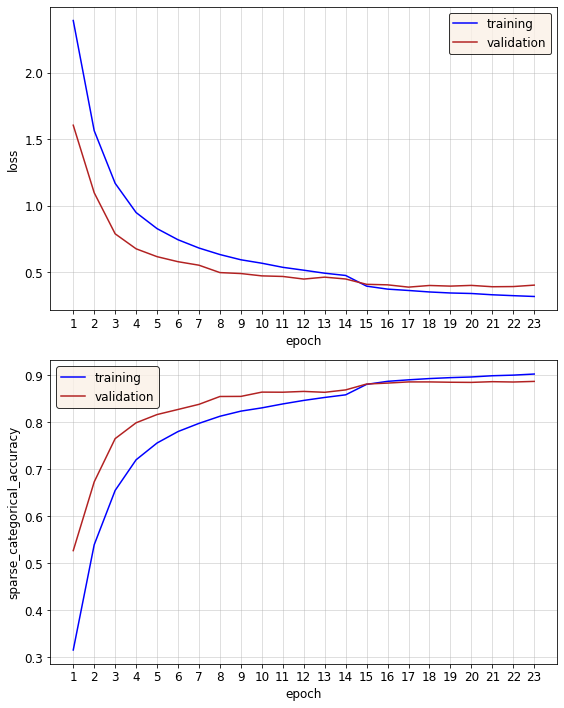

In [25]:
plot_utils.plot_history(results, columns=['loss', 'sparse_categorical_accuracy'])

Uncomment the cell below to save the trained model.



In [26]:
model.save(f'trained_models/{model_name}.h5')

try:
  from google.colab import files
  files.download(f'trained_models/{model_name}.h5')

except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3.2 - Model testing

344/344 [==============================] - 50s 142ms/step


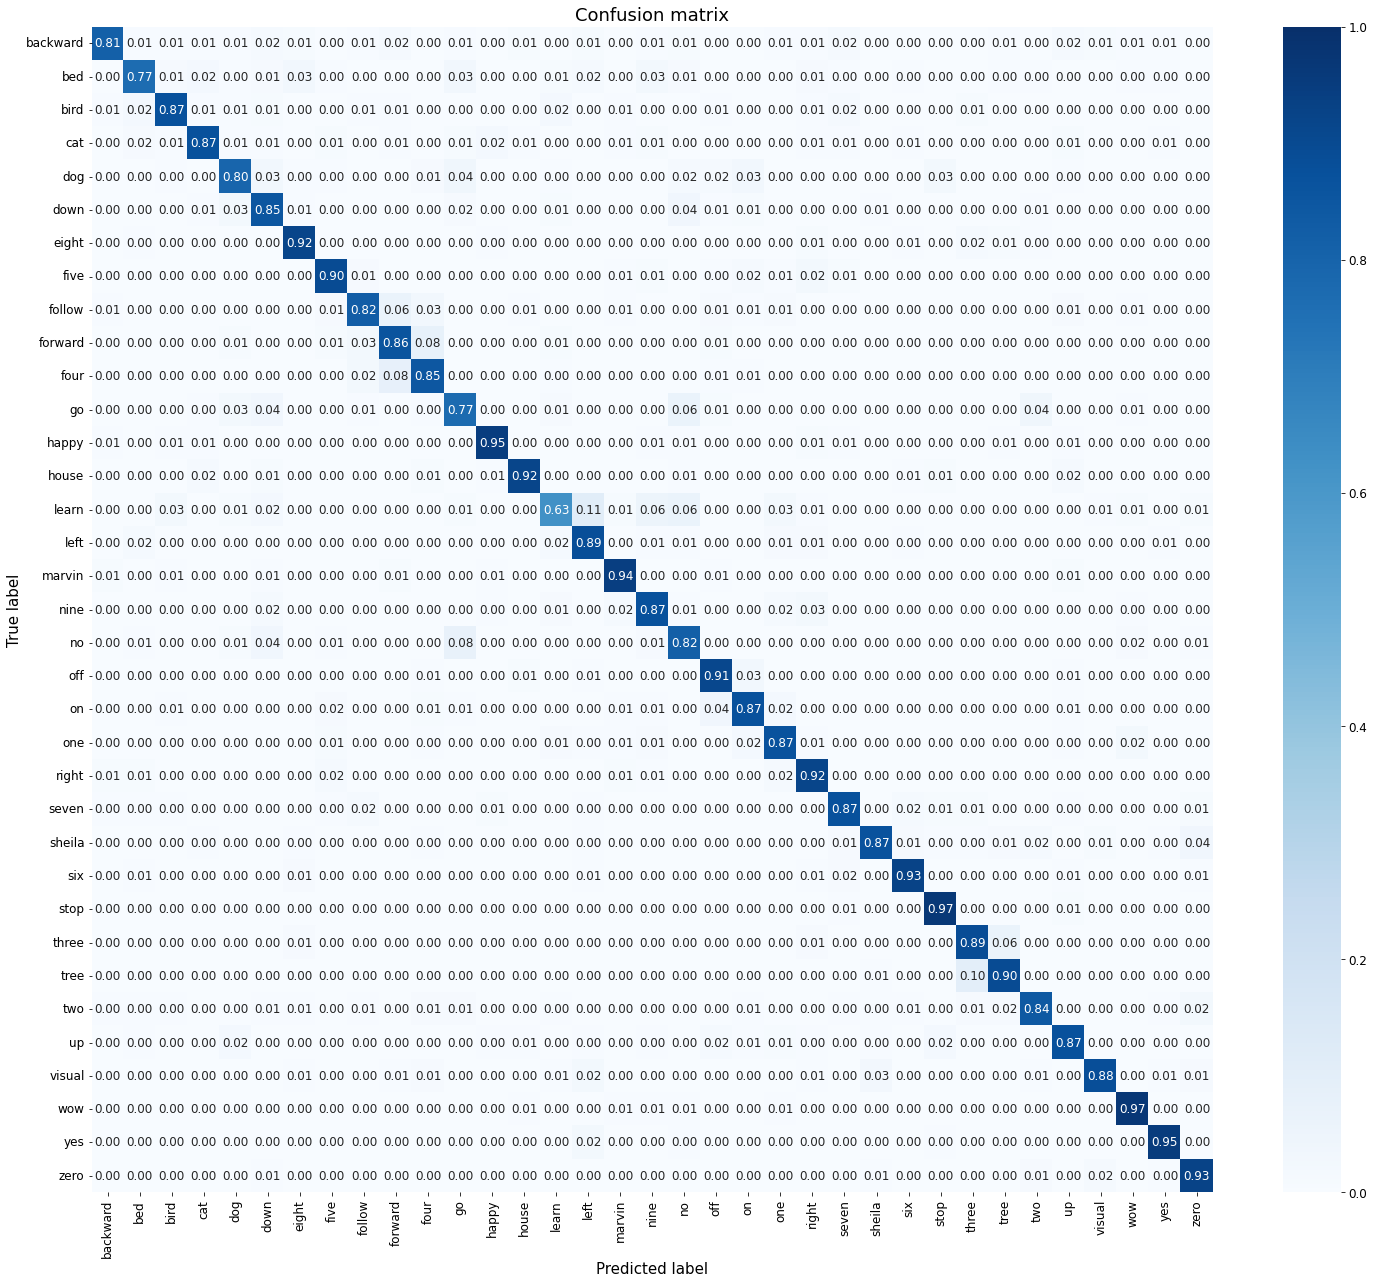

In [27]:
# get predictions for test set
test_labels = reference_df_test['class']
test_pred = model.predict(test_dataset, steps=test_steps, verbose=1)[:len(test_labels)].squeeze()

# estimate class
y_pred = np.argmax(test_pred, axis=1)

# true labels
y_true = reference_df_test['class'].tolist()

# plot cm
cm = confusion_matrix(y_pred, y_true)
plot_utils.plot_confusion_matrix(cm, labels=commands, normalize=True, saveit=False, model_name='')

In [28]:
def class_report(y_true, y_pred):
    precision_macro,    recall_macro,    fscore_macro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='macro')
    precision_micro,    recall_micro,    fscore_micro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='micro')
    precision_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted')
    
    df_report = pd.DataFrame(
        {
            'precision': [precision_macro, precision_micro, precision_weighted],
            'recall': [recall_macro, recall_micro, recall_weighted],
            'f1-score': [fscore_macro, fscore_micro, fscore_weighted]
        }, 
        index=['macro', 'micro', 'weighted']
    )
    
    return df_report

# get metrics and display them 
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
logloss  = log_loss(y_true, test_pred, labels=np.arange(35))
cohen_k  = cohen_kappa_score(y_true, y_pred)

# print('Accuracy:      {:.2f}%'.format(accuracy*100))
# print('Error rate:    {:.2f}%'.format((1-accuracy)*100))
# print('Cross-entropy: {:.4f}'.format(logloss))
# print("Cohen's Kappa: {:.4f}".format(cohen_k))

cr = class_report(y_true, y_pred)
weighted_metrics = cr.iloc[-1].tolist()

df_metrics_modified = pd.DataFrame(
    [weighted_metrics + [accuracy, logloss, cohen_k]], 
    columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa'], 
)

display(df_metrics_modified.round(4))

,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
0,0.8791,0.8773,0.8773,0.8773,0.4288,0.8732


## 4 - Attention Model

### 4.1 - Model definition and training

In [29]:
available_models()

Available models:
cnn_trad_fpool3
cnn_one_fpool3
cnn_one_fstride4
cnn_one_fstride8
custom_cnn_simple
custom_cnn
residual_block
resnet
RNNSpeechModel
AttRNNSpeechModel


In [30]:
# features_to_input = { # input shapes
#     1 : (99, 39),     # MFCC features with delta
#     2 : (99, 40),     # log Mel-filterbank energy features
#     3 : (98, 257),    # spectrogram
#     4 : (49, 39),      # Discrete Wavelet Transform + MFCC features
#     5 : (99, 13)      # MFCC features no delta
# }

input_shape = (99, 40)
model_name  = 'AttRNNSpeechModel'
model = select_model(model_name, input_shape) #rnn_func=L.LSTM)

from models_utils import AttRNNSpeechModel
print(inspect.getsource(AttRNNSpeechModel))

Selected model: AttRNNSpeechModel
def AttRNNSpeechModel(input_shape=(99, 40), output_shape=35, rnn_func=L.LSTM):
    # simple LSTM
    input_layer = L.Input(shape=input_shape)
    x = L.Reshape(input_shape=input_shape, target_shape=(input_shape[0], input_shape[1], 1))(input_layer)

    # x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)
    # x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(0.3)(x)

    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = L.Bidirectional(rnn_func(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]
    x = L.Bidirectional(rnn_func(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]

    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
 

In [31]:
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "AttRNNSpeechModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 99, 40)]     0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 99, 40, 1)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 99, 40, 10)   60          ['reshape_1[0][0]']              
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 99, 40, 10)  40          ['conv2d_2[0][0]']               
 rmalization)                                                                     

In [32]:
num_epochs = 40

early_stop_callback = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('RNN.h5', monitor='val_loss', verbose=1, save_best_only=True)

results = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset, 
    validation_steps=val_steps,
    epochs=num_epochs,
    callbacks=[early_stop_callback, model_checkpoint, reduce_LR], 
    verbose=1
)

Changing learning rate to 0.001
Epoch 1/40
2652/2652 [==============================] - ETA: 0s - loss: 2.7251 - sparse_categorical_accuracy: 0.2306
Epoch 1: val_loss improved from inf to 1.70827, saving model to RNN.h5
2652/2652 [==============================] - 68s 23ms/step - loss: 2.7251 - sparse_categorical_accuracy: 0.2306 - val_loss: 1.7083 - val_sparse_categorical_accuracy: 0.4939 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/40
2651/2652 [============================>.] - ETA: 0s - loss: 1.6634 - sparse_categorical_accuracy: 0.5103
Epoch 2: val_loss improved from 1.70827 to 1.21028, saving model to RNN.h5
2652/2652 [==============================] - 62s 23ms/step - loss: 1.6634 - sparse_categorical_accuracy: 0.5103 - val_loss: 1.2103 - val_sparse_categorical_accuracy: 0.6406 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/40
2650/2652 [============================>.] - ETA: 0s - loss: 1.3231 - sparse_categorical_accuracy: 0.6091
Epoch 3: val_loss improved from 1.2

In [33]:
# print('Training history:')
# pd.DataFrame(history.history)

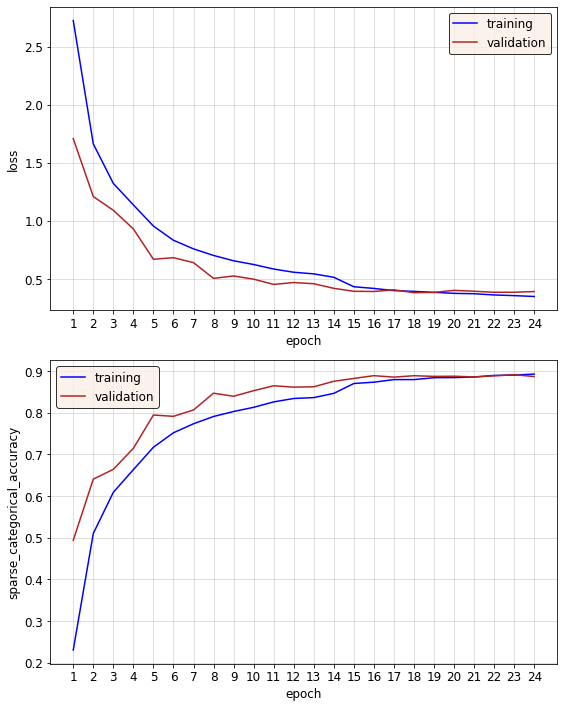

In [34]:
plot_utils.plot_history(results, columns=['loss', 'sparse_categorical_accuracy'])

Uncomment the cell below to save the trained model.



In [35]:
model.save(f'trained_models/{model_name}.h5')

try:
  from google.colab import files
  files.download(f'trained_models/{model_name}.h5')

except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 4.2 - Model testing

344/344 [==============================] - 5s 9ms/step


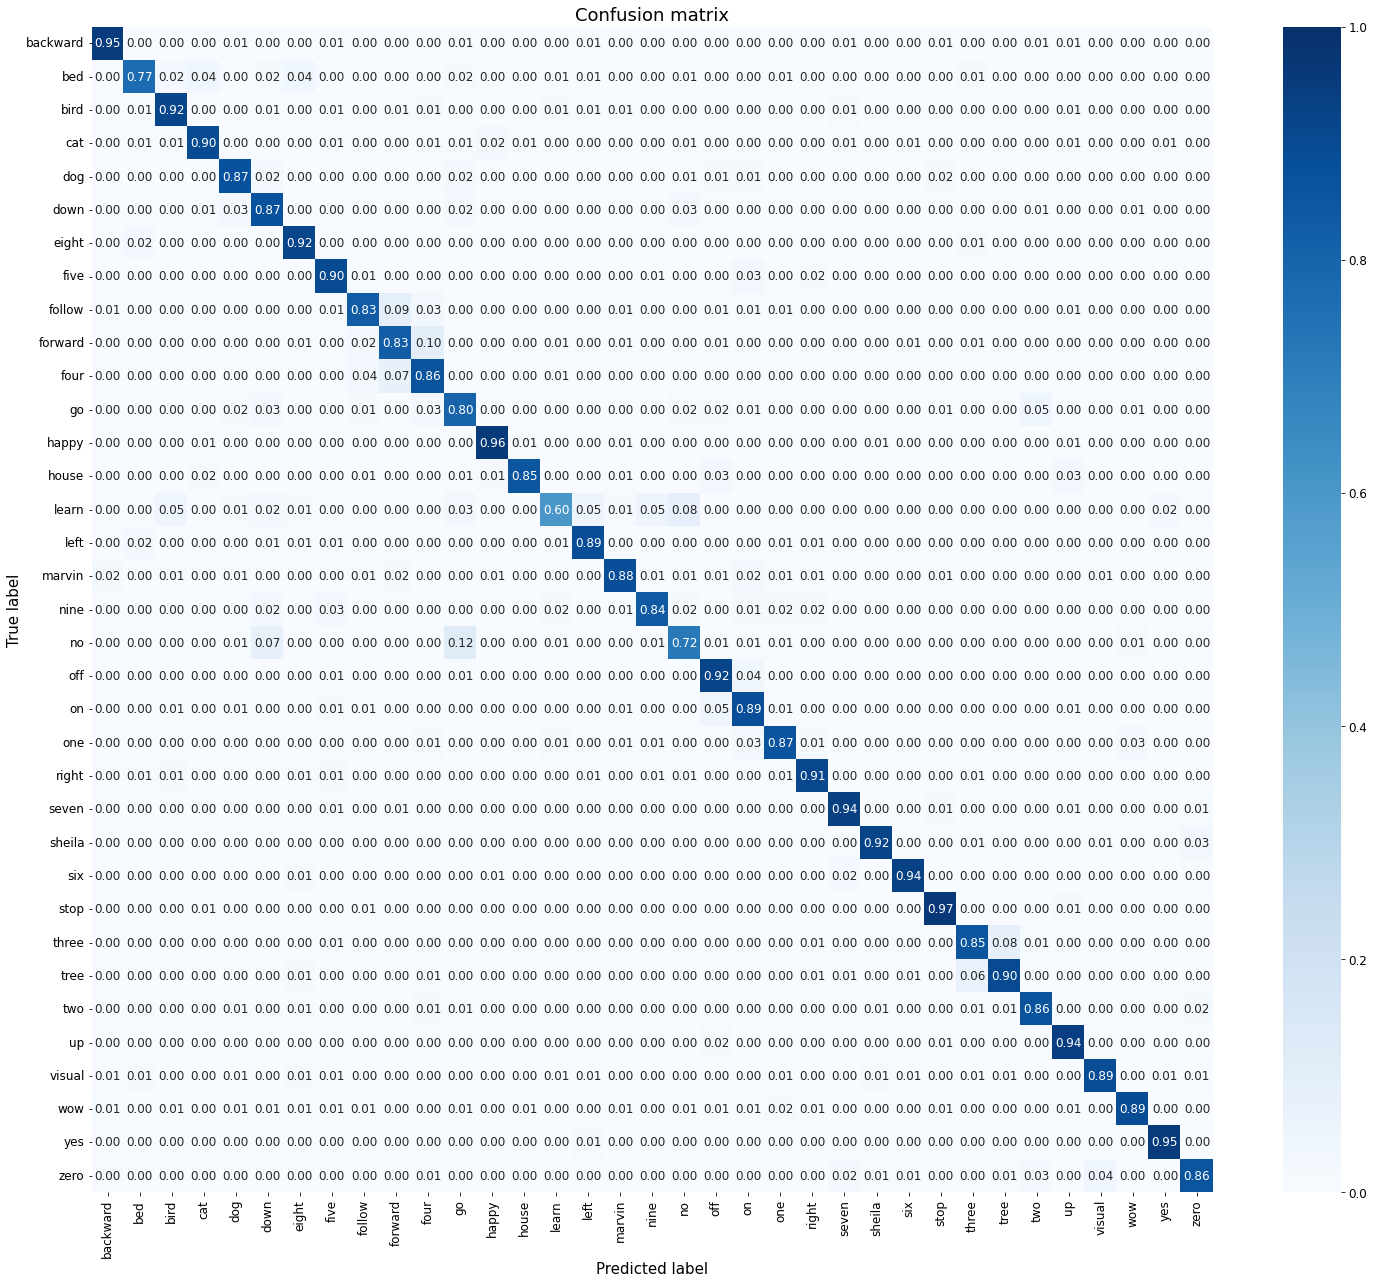

In [36]:
# get predictions for test set
test_labels = reference_df_test['class']
test_pred = model.predict(test_dataset, steps=test_steps, verbose=1)[:len(test_labels)].squeeze()

# estimate class
y_pred = np.argmax(test_pred, axis=1)

# true labels
y_true = reference_df_test['class'].tolist()

# plot cm
cm = confusion_matrix(y_pred, y_true)
plot_utils.plot_confusion_matrix(cm, labels=commands, normalize=True, saveit=False, model_name='')

In [37]:
def class_report(y_true, y_pred):
    precision_macro,    recall_macro,    fscore_macro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='macro')
    precision_micro,    recall_micro,    fscore_micro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='micro')
    precision_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted')
    
    df_report = pd.DataFrame(
        {
            'precision': [precision_macro, precision_micro, precision_weighted],
            'recall': [recall_macro, recall_micro, recall_weighted],
            'f1-score': [fscore_macro, fscore_micro, fscore_weighted]
        }, 
        index=['macro', 'micro', 'weighted']
    )
    
    return df_report

# get metrics and display them 
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
logloss  = log_loss(y_true, test_pred, labels=np.arange(35))
cohen_k  = cohen_kappa_score(y_true, y_pred)

# print('Accuracy:      {:.2f}%'.format(accuracy*100))
# print('Error rate:    {:.2f}%'.format((1-accuracy)*100))
# print('Cross-entropy: {:.4f}'.format(logloss))
# print("Cohen's Kappa: {:.4f}".format(cohen_k))

cr = class_report(y_true, y_pred)
weighted_metrics = cr.iloc[-1].tolist()

df_metrics_modified = pd.DataFrame(
    [weighted_metrics + [accuracy, logloss, cohen_k]], 
    columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa'], 
)

display(df_metrics_modified.round(4))

,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
0,0.881,0.8781,0.8783,0.8781,0.4207,0.8741


### 4.3 - Attention Plots
First we create a dataframe containing 1 sample per class.

In [38]:
reference_df_analysis = reference_df_test[reference_df_test['class']==0].iloc[:1]

for i in np.arange(1, 35):
  reference_df_analysis = reference_df_analysis.append(reference_df_test[reference_df_test['class']==i].iloc[:1])

reference_df_analysis.reset_index(inplace=True, drop=True)

display(reference_df_analysis)

,label,file,class
0,backward,bb05582b_nohash_3.wav,0
1,bed,3f170018_nohash_0.wav,1
2,bird,5c8af87a_nohash_0.wav,2
3,cat,aef8dcf5_nohash_0.wav,3
4,dog,f428ca69_nohash_1.wav,4
5,down,bb05582b_nohash_3.wav,5
6,eight,bb05582b_nohash_3.wav,6
7,five,bb05582b_nohash_3.wav,7
8,follow,bb05582b_nohash_3.wav,8
9,forward,bb05582b_nohash_3.wav,9


In [39]:
from keras.models import Model

attSpeechModel = Model(
    inputs  = model.input, 
    outputs = [
      model.get_layer('output').output, 
      model.get_layer('attSoftmax').output
    ]
)

# create dataset
audios_dataset, audios_steps = create_dataset(
    reference_df_analysis,
    is_train=False,
    cache_file='test_cache',
    shuffle=False,
    apply_background_noise=False,
    features=features_to_extract,
    batch_size=batch_size
)

# load signals
signals = []
for i in range(35):
  signals.append(preprocessing_utils.load_data(reference_df_analysis.iloc[i].file, reference_df_analysis.iloc[i].label))

# load mfcc 
mfcc_schemes = []
for i in range(35):
  mfcc_schemes.append(preprocessing_utils.get_logfbank(preprocessing_utils.load_and_preprocess_data(reference_df_analysis.iloc[i].file, reference_df_analysis.iloc[i].label)))

In [40]:
# predict analysis dataset
outs, attW = attSpeechModel.predict(audios_dataset, steps=audios_steps, verbose=1)
outs = outs[:35].squeeze()
attW = attW[:35].squeeze()

outs_classification = np.argmax(outs,axis=1)

df_ = pd.DataFrame({
    'True_label': reference_df_analysis['label'], 
    'True_class': reference_df_analysis['class'], 
    'Predicted_label': outs_classification,
    'Is_correct': [True if x==y else False for x, y in zip(reference_df_analysis['class'], outs_classification)]
  }
)
display(df_)

2/2 [==============================] - 2s 23ms/step


,True_label,True_class,Predicted_label,Is_correct
0,backward,0,0,True
1,bed,1,1,True
2,bird,2,2,True
3,cat,3,3,True
4,dog,4,4,True
5,down,5,5,True
6,eight,6,25,False
7,five,7,7,True
8,follow,8,8,True
9,forward,9,9,True


In [41]:
# select signals to plot
idAudio_selected = [18, 33]
print('Classes selected: ', [class_to_label[i] for i in idAudio_selected])

Classes selected:  ['no', 'yes']


Class 'no':


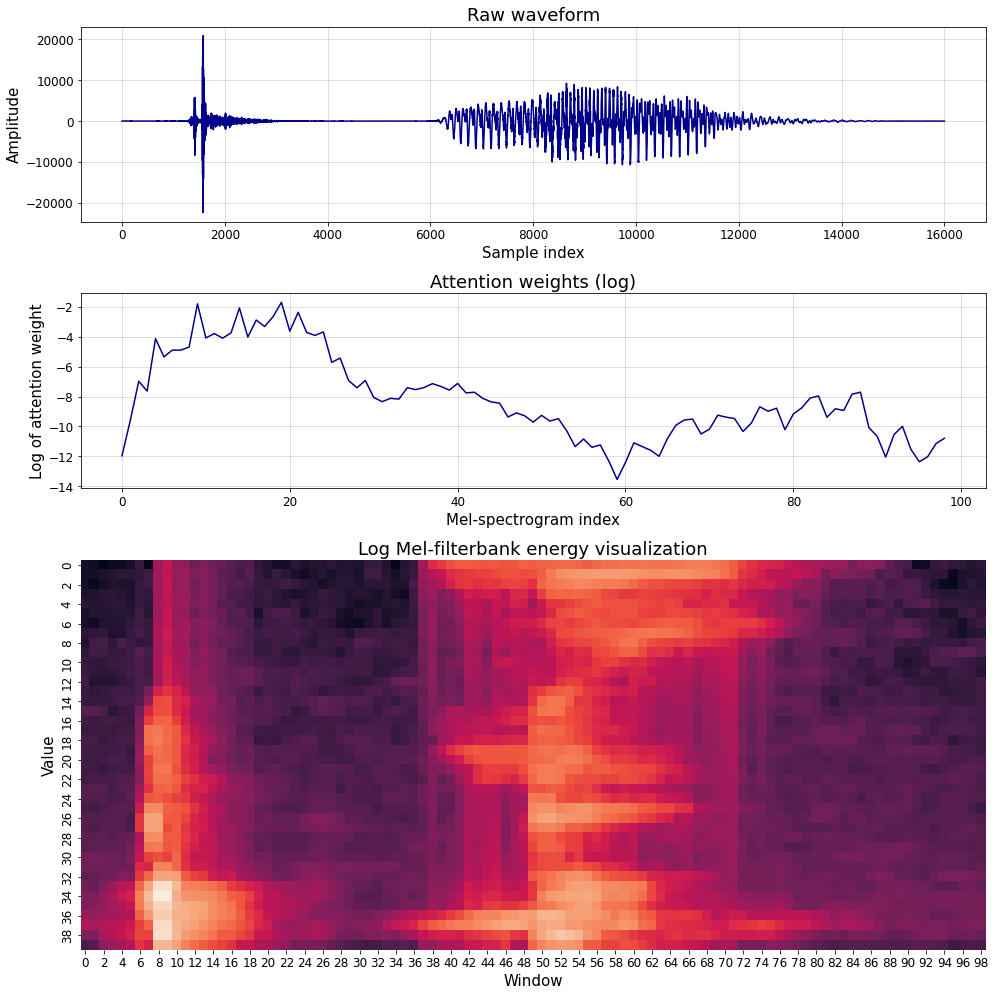



Class 'yes':


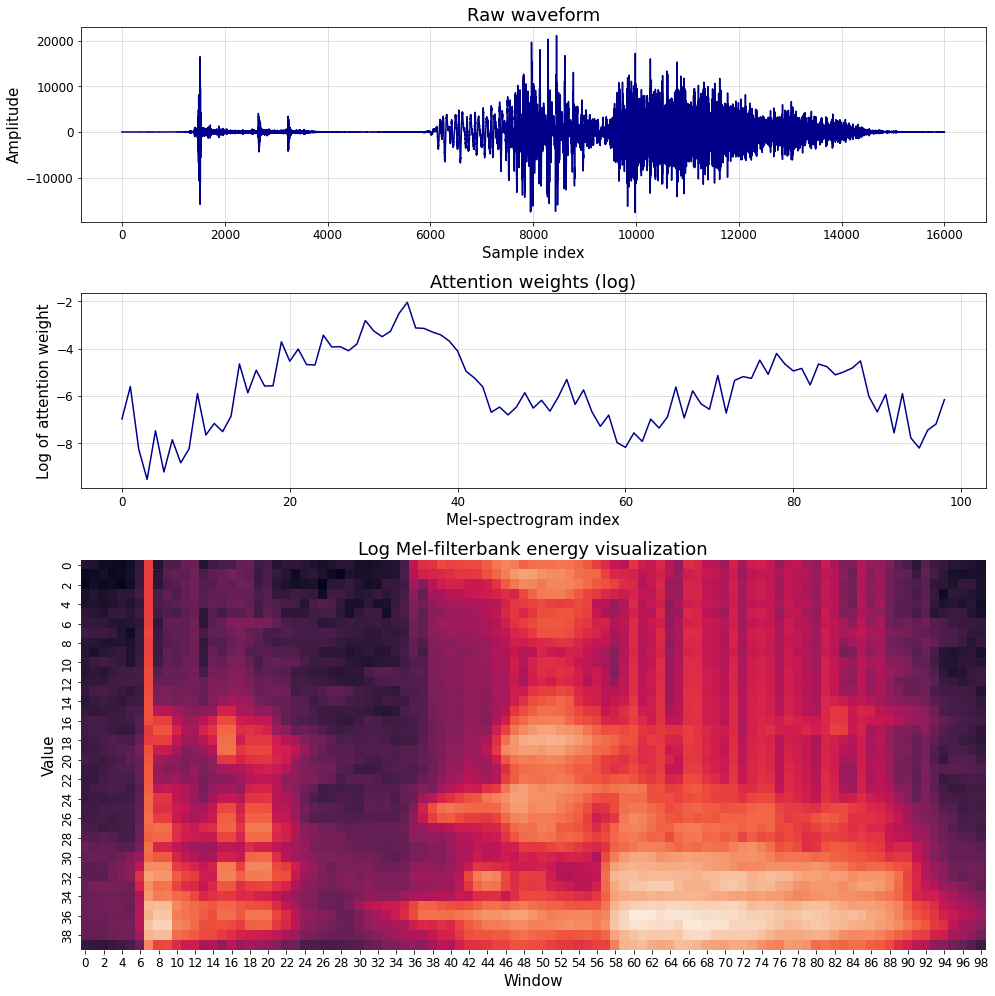

In [42]:
for idAudio in idAudio_selected:
  print('\x1b[1;37;40m' + "Class '%s':" %class_to_label[idAudio] + '\x1b[0m')
  fig, (ax0, ax1, ax2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1, 2]}, figsize=(14, 14))

  ax0.plot(signals[idAudio], color='darkblue')
  ax0.set_title('Raw waveform', fontsize=18)
  ax0.set_ylabel('Amplitude', fontsize=15)
  ax0.set_xlabel('Sample index', fontsize=15)
  ax0.grid(alpha=0.5)

  ax1.plot(np.log(attW[idAudio]), color='darkblue')
  ax1.set_title('Attention weights (log)', fontsize=18)
  ax1.set_ylabel('Log of attention weight', fontsize=15)
  ax1.set_xlabel('Mel-spectrogram index', fontsize=15)
  ax1.grid(alpha=0.5)

  ax2 = sns.heatmap(mfcc_schemes[idAudio], cbar=False)
  ax2.set_title('Log Mel-filterbank energy visualization', fontsize=18)
  ax2.set_ylabel('Value', fontsize=15)
  ax2.set_xlabel('Window', fontsize=15)

  plt.tight_layout()
  plt.show()
  
  print('\n')

## 5 - Attention Model, modifing input window

### 5.0 - Dataset definition and initialization

In [23]:
'''
    features_to_extract:
    - 1 for MFCC features [delta_order=2] (default)
    - 2 for log Mel-filterbank energy features
    - 3 for spectrogram
    - 4 for Discrete Wavelet Transform + MFCC features
    - 5 for MFCC features [delta_order=0]
    - 6 for log Mel-filterbank energy features [winlen=32, winstep=15.5, nfilt=64]
    - 7 for log Mel-filterbank energy features [winlen=25, winstep=8,    nfilt=80]
    else the original signal without feature extraction is returned
'''

preprocessing_utils.remove_file_starting_with('train_cache')
preprocessing_utils.remove_file_starting_with('val_cache')
preprocessing_utils.remove_file_starting_with('test_cache')

features_to_extract = 7
apply_bn = True
noise_red = 0.5
batch_size = 32

train_dataset, train_steps = create_dataset(
    reference_df_train,
    is_train=True,
    cache_file='train_cache',
    shuffle=True,
    apply_background_noise=apply_bn,
    noise_dict=noise_dict,
    noise_reduction=noise_red,
    features=features_to_extract,
    batch_size=batch_size
)

val_dataset, val_steps = create_dataset(
    reference_df_val,
    is_train=False,
    cache_file='val_cache',
    shuffle=True,
    apply_background_noise=False,
    features=features_to_extract,
    batch_size=batch_size
)

# important! shuffle=False
test_dataset, test_steps = create_dataset(
    reference_df_test,
    is_train=False,
    cache_file='test_cache',
    shuffle=False,
    apply_background_noise=False,
    features=features_to_extract,
    batch_size=batch_size
)

### 5.1 - Model definition and training

In [24]:
available_models()

Available models:
cnn_trad_fpool3
cnn_one_fpool3
cnn_one_fstride4
cnn_one_fstride8
custom_cnn_simple
custom_cnn
residual_block
resnet
RNNSpeechModel
AttRNNSpeechModel


In [30]:
# features_to_input = { # input shapes
#     1 : (99, 39),     # MFCC features with delta
#     2 : (99, 40),     # log Mel-filterbank energy features
#     3 : (98, 257),    # spectrogram
#     4 : (49, 39),      # Discrete Wavelet Transform + MFCC features
#     5 : (99, 13)      # MFCC features no delta
# }

input_shape = (123, 80)
model_name  = 'AttRNNSpeechModel'
model = select_model(model_name, input_shape) #rnn_func=L.LSTM)

model_name  = 'AttRNNSpeechModel2'

from models_utils import AttRNNSpeechModel
print(inspect.getsource(AttRNNSpeechModel))

Selected model: AttRNNSpeechModel
def AttRNNSpeechModel(input_shape=(99, 40), output_shape=35, rnn_func=L.LSTM):
    # simple LSTM
    input_layer = L.Input(shape=input_shape)
    x = L.Reshape(input_shape=input_shape, target_shape=(input_shape[0], input_shape[1], 1))(input_layer)

    # x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)
    # x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(0.3)(x)

    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = L.Bidirectional(rnn_func(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]
    x = L.Bidirectional(rnn_func(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]

    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
 

In [31]:
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "AttRNNSpeechModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 123, 80)]    0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 123, 80, 1)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 123, 80, 10)  60          ['reshape_1[0][0]']              
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 123, 80, 10)  40         ['conv2d_2[0][0]']               
 rmalization)                                                                     

In [32]:
num_epochs = 60

early_stop_callback = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('RNN.h5', monitor='val_loss', verbose=1, save_best_only=True)

reduce_LR = LearningRateScheduler(step_decay)

results = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset, 
    validation_steps=val_steps,
    epochs=num_epochs,
    callbacks=[early_stop_callback, model_checkpoint, reduce_LR], 
    verbose=1
)

Changing learning rate to 0.001
Epoch 1/60
2652/2652 [==============================] - ETA: 0s - loss: 3.0621 - sparse_categorical_accuracy: 0.1467
Epoch 1: val_loss improved from inf to 2.34394, saving model to RNN.h5
2652/2652 [==============================] - 77s 26ms/step - loss: 3.0621 - sparse_categorical_accuracy: 0.1467 - val_loss: 2.3439 - val_sparse_categorical_accuracy: 0.3231 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/60
2652/2652 [==============================] - ETA: 0s - loss: 2.1212 - sparse_categorical_accuracy: 0.3839
Epoch 2: val_loss improved from 2.34394 to 1.66179, saving model to RNN.h5
2652/2652 [==============================] - 70s 26ms/step - loss: 2.1212 - sparse_categorical_accuracy: 0.3839 - val_loss: 1.6618 - val_sparse_categorical_accuracy: 0.5119 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/60
2652/2652 [==============================] - ETA: 0s - loss: 1.6733 - sparse_categorical_accuracy: 0.5103
Epoch 3: val_loss improved from 1.6

In [33]:
# print('Training history:')
# pd.DataFrame(history.history)

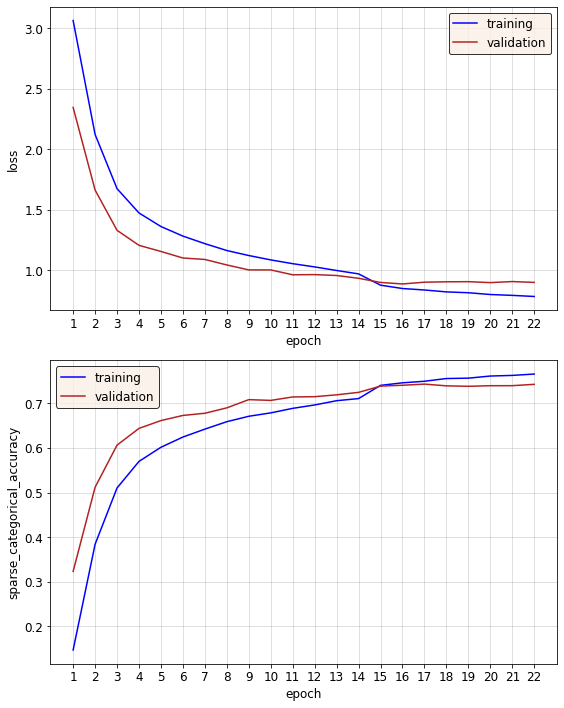

In [34]:
plot_utils.plot_history(results, columns=['loss', 'sparse_categorical_accuracy'])

Uncomment the cell below to save the trained model.



In [35]:
model.save(f'trained_models/{model_name}.h5')

try:
  from google.colab import files
  files.download(f'trained_models/{model_name}.h5')

except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 4.2 - Model testing

344/344 [==============================] - 42s 117ms/step


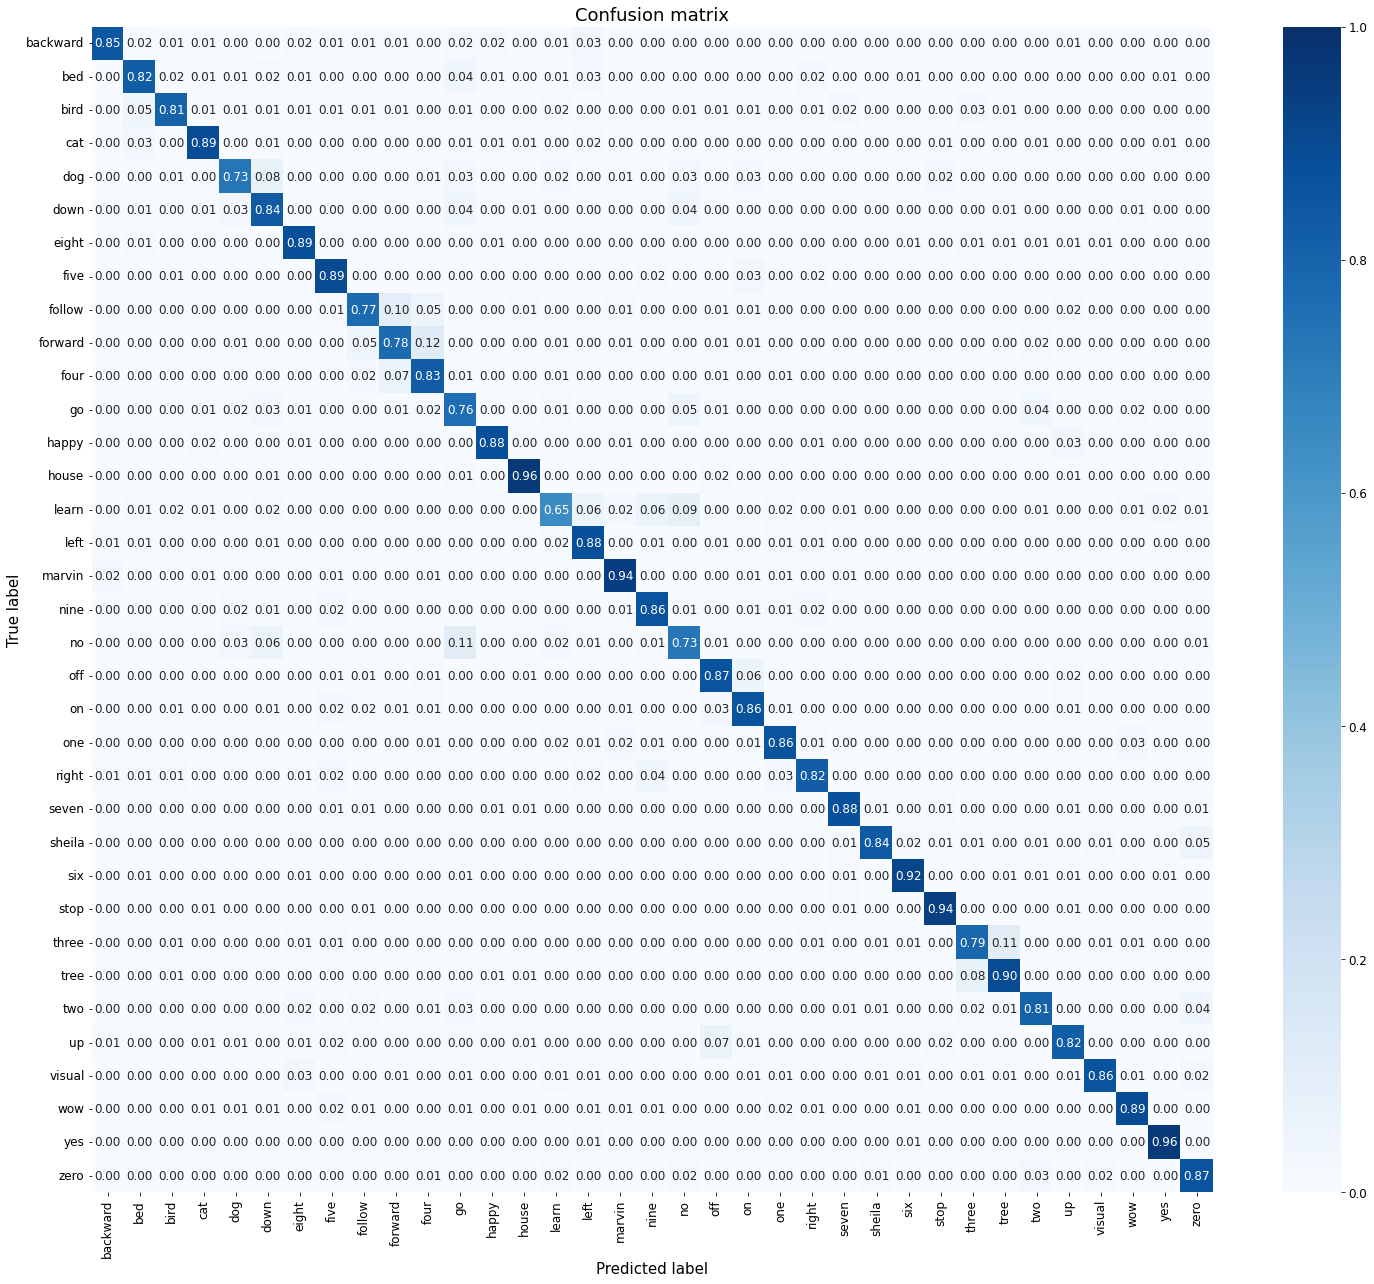

In [36]:
# get predictions for test set
test_labels = reference_df_test['class']
test_pred = model.predict(test_dataset, steps=test_steps, verbose=1)[:len(test_labels)].squeeze()

# estimate class
y_pred = np.argmax(test_pred, axis=1)

# true labels
y_true = reference_df_test['class'].tolist()

# plot cm
cm = confusion_matrix(y_pred, y_true)
plot_utils.plot_confusion_matrix(cm, labels=commands, normalize=True, saveit=False, model_name='')

In [37]:
def class_report(y_true, y_pred):
    precision_macro,    recall_macro,    fscore_macro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='macro')
    precision_micro,    recall_micro,    fscore_micro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='micro')
    precision_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted')
    
    df_report = pd.DataFrame(
        {
            'precision': [precision_macro, precision_micro, precision_weighted],
            'recall': [recall_macro, recall_micro, recall_weighted],
            'f1-score': [fscore_macro, fscore_micro, fscore_weighted]
        }, 
        index=['macro', 'micro', 'weighted']
    )
    
    return df_report

# get metrics and display them 
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
logloss  = log_loss(y_true, test_pred, labels=np.arange(35))
cohen_k  = cohen_kappa_score(y_true, y_pred)

# print('Accuracy:      {:.2f}%'.format(accuracy*100))
# print('Error rate:    {:.2f}%'.format((1-accuracy)*100))
# print('Cross-entropy: {:.4f}'.format(logloss))
# print("Cohen's Kappa: {:.4f}".format(cohen_k))

cr = class_report(y_true, y_pred)
weighted_metrics = cr.iloc[-1].tolist()

df_metrics_modified = pd.DataFrame(
    [weighted_metrics + [accuracy, logloss, cohen_k]], 
    columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa'], 
)

display(df_metrics_modified.round(4))

,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
0,0.85,0.8486,0.8479,0.8486,0.5365,0.8435


### 4.3 - Attention Plots
First we create a dataframe containing 1 sample per class.

In [38]:
reference_df_analysis = reference_df_test[reference_df_test['class']==0].iloc[:1]

for i in np.arange(1, 35):
  reference_df_analysis = reference_df_analysis.append(reference_df_test[reference_df_test['class']==i].iloc[:1])

reference_df_analysis.reset_index(inplace=True, drop=True)

display(reference_df_analysis)

,label,file,class
0,backward,bb05582b_nohash_3.wav,0
1,bed,3f170018_nohash_0.wav,1
2,bird,5c8af87a_nohash_0.wav,2
3,cat,aef8dcf5_nohash_0.wav,3
4,dog,f428ca69_nohash_1.wav,4
5,down,bb05582b_nohash_3.wav,5
6,eight,bb05582b_nohash_3.wav,6
7,five,bb05582b_nohash_3.wav,7
8,follow,bb05582b_nohash_3.wav,8
9,forward,bb05582b_nohash_3.wav,9


In [39]:
from keras.models import Model

attSpeechModel = Model(
    inputs  = model.input, 
    outputs = [
      model.get_layer('output').output, 
      model.get_layer('attSoftmax').output
    ]
)

# create dataset
audios_dataset, audios_steps = create_dataset(
    reference_df_analysis,
    is_train=False,
    cache_file='test_cache',
    shuffle=False,
    apply_background_noise=False,
    features=features_to_extract,
    batch_size=batch_size
)

# load signals
signals = []
for i in range(35):
  signals.append(preprocessing_utils.load_data(reference_df_analysis.iloc[i].file, reference_df_analysis.iloc[i].label))

# load mfcc 
mfcc_schemes = []
for i in range(35):
  mfcc_schemes.append(preprocessing_utils.get_logfbank(preprocessing_utils.load_and_preprocess_data(reference_df_analysis.iloc[i].file, reference_df_analysis.iloc[i].label), winlen=25, winstep=8, nfilt=80))

In [40]:
# predict analysis dataset
outs, attW = attSpeechModel.predict(audios_dataset, steps=audios_steps, verbose=1)
outs = outs[:35].squeeze()
attW = attW[:35].squeeze()

outs_classification = np.argmax(outs,axis=1)

df_ = pd.DataFrame({
    'True_label': reference_df_analysis['label'], 
    'True_class': reference_df_analysis['class'], 
    'Predicted_label': outs_classification,
    'Is_correct': [True if x==y else False for x, y in zip(reference_df_analysis['class'], outs_classification)]
  }
)
display(df_)

2/2 [==============================] - 2s 54ms/step


,True_label,True_class,Predicted_label,Is_correct
0,backward,0,30,False
1,bed,1,1,True
2,bird,2,2,True
3,cat,3,3,True
4,dog,4,4,True
5,down,5,5,True
6,eight,6,6,True
7,five,7,7,True
8,follow,8,29,False
9,forward,9,9,True


In [41]:
# select signals to plot
idAudio_selected = [18, 33]
print('Classes selected: ', [class_to_label[i] for i in idAudio_selected])

Classes selected:  ['no', 'yes']


Class 'no':


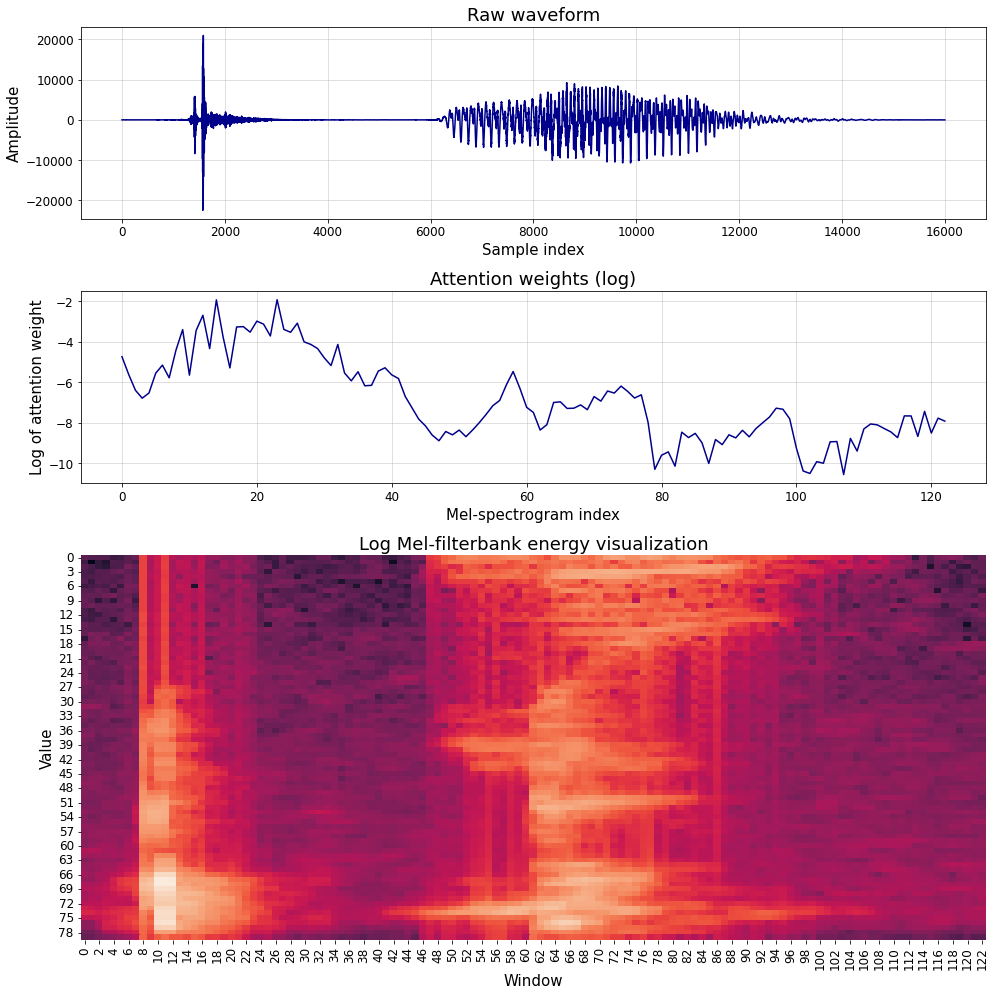



Class 'yes':


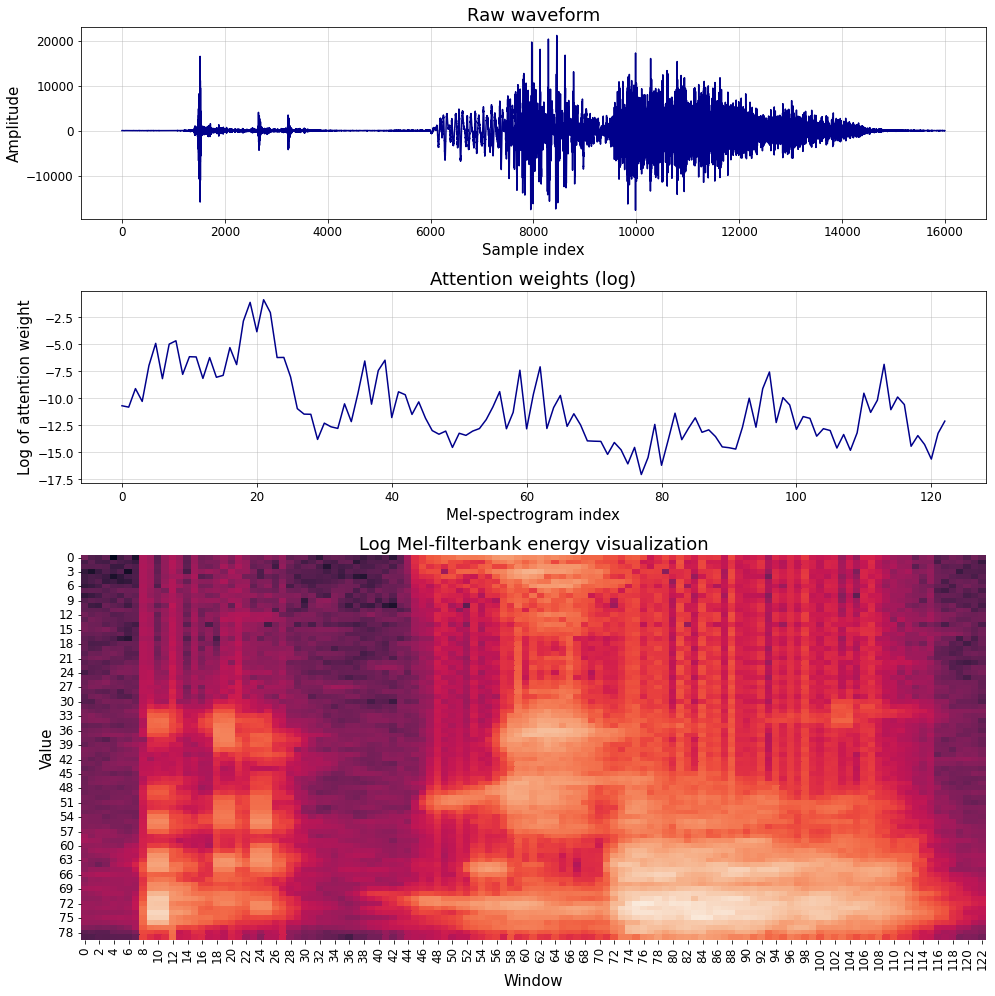

In [42]:
for idAudio in idAudio_selected:
  print('\x1b[1;37;40m' + "Class '%s':" %class_to_label[idAudio] + '\x1b[0m')
  fig, (ax0, ax1, ax2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1, 2]}, figsize=(14, 14))

  ax0.plot(signals[idAudio], color='darkblue')
  ax0.set_title('Raw waveform', fontsize=18)
  ax0.set_ylabel('Amplitude', fontsize=15)
  ax0.set_xlabel('Sample index', fontsize=15)
  ax0.grid(alpha=0.5)

  ax1.plot(np.log(attW[idAudio]), color='darkblue')
  ax1.set_title('Attention weights (log)', fontsize=18)
  ax1.set_ylabel('Log of attention weight', fontsize=15)
  ax1.set_xlabel('Mel-spectrogram index', fontsize=15)
  ax1.grid(alpha=0.5)

  ax2 = sns.heatmap(mfcc_schemes[idAudio], cbar=False)
  ax2.set_title('Log Mel-filterbank energy visualization', fontsize=18)
  ax2.set_ylabel('Value', fontsize=15)
  ax2.set_xlabel('Window', fontsize=15)

  plt.tight_layout()
  plt.show()
  
  print('\n')

# References
**[Sainath15]** <br>
 Tara N. Sainath, Carolina Parada, _Convolutional Neural Networks for Small-footprint Keyword Spotting_, INTERSPEECH, Dresden, Germany, September 2015.

**[Warden18]** <br>
 Pete Warden, _Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition_, arXiv:1804.03209, April 2018. 
 
**[Lyons14]** <br>
 James Lyons et al. (2020, January 14). jameslyons/python_speech_features: release v0.6.1 (Version 0.6.1). Zenodo.

**[Andrade18]** <br>
Andrade, D.C., Leo, S., Viana, M., & Bernkopf, C. (2018). _A neural attention model for speech command recognition_. ArXiv, abs/1808.08929.

**[Chorowski15]** <br>
Chorowski, J., Bahdanau, D., Serdyuk, D., Cho, K., & Bengio, Y. (2015). _Attention-Based Models for Speech Recognition_. ArXiv, abs/1506.07503.